In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

sc.settings.set_figure_params(dpi=250)

In [2]:
# Reference
# https://hbctraining.github.io/scRNA-seq_online/lessons/pseudobulk_DESeq2_scrnaseq.html

# Read Files

## Gastrulation

In [4]:
gast = pd.read_excel("Data/Gastrulation.xlsx", header=1)
gast = gast.iloc[:20544, :]
gast["Symbol"] = [i.split("(")[-1].split(')')[0] for i in gast.Gene]

In [5]:
cols = pd.read_excel("Data/Gastrulation_Raw.xlsx", header=0)
gast_raw = pd.read_excel("Data/Gastrulation_Raw.xlsx", header=2)
gast_raw.columns = cols.columns.tolist()
gast_raw = gast_raw.fillna(0)

In [6]:
gast_raw["Symbol"] = [gast.loc[gast['Accession No']==i, "Symbol"].values[0] if i in gast['Accession No'].values else "Not found" for i in gast_raw.Raw]

In [7]:
g = gast_raw[gast_raw.Symbol!="Not found"]
g = g.set_index(g.Symbol)
g = g.iloc[:, 1:-1]
g = g.T
g

Symbol,MIR2404-2,MIR2292,MIR2285B,MIR2423,MIR2450B,MIR2411,MIR2465,MIR2315,MIR197,MIR29B-2,...,PPP2R2B,SZRD1,MPHOSPH9,MARF1,GNAS,KIAA0430,ATP5SL,ATAT1,SEMA3A,ACE2
St4 Disc,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,206.0,4.0,716.0,60.0,9.0,3.0,15.0,122.0,30.0,0.0
St5 PH,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,157.0,1.0,1354.0,54.0,6.0,16.0,0.0,47.0,1.0,1.0
St5 TB,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,...,22.0,0.0,1521.0,19.0,8.0,5.0,2.0,37.0,2.0,0.0
St5 MEH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,393.0,5.0,2404.0,103.0,22.0,53.0,4.0,223.0,1.0,1.0
St5 EE,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,191.0,0.0,1634.0,45.0,20.0,22.0,2.0,201.0,52.0,0.0


## Raw counts - Blastoids

In [8]:
meta = pd.read_csv('Data/Obs_lines.csv', index_col=0)

In [9]:
rawall = sc.read_h5ad('Data/adata.h5ad')
raw = rawall[rawall.obs.data=="data0_Carlos"].copy()
raw = raw[raw.obs.index.isin(meta.index)].copy()
raw

AnnData object with n_obs × n_vars = 3532 × 22168
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tech', 'celltype', 'data', 'percent.mt', 'sample', 'source', 'ident'
    layers: 'logcounts'

In [10]:
raw.obs["New_Lines"] = [meta.loc[i, "New_Lines"] for i in raw.obs.index]

In [11]:
d = pd.DataFrame(raw.X.todense())

In [12]:
d.columns = raw.var_names
d.index = raw.obs.index

In [13]:
d['Lines'] = raw.obs.New_Lines

In [14]:
pseudo = d.groupby('Lines').sum()

In [15]:
pseudo = pseudo.loc[~pseudo.index.isin(['Early_Blastocyst', "Early_embryo"])]
pseudo

,ENSBTAG00000001753,CBX3,RCAN1,KCNE1,SMIM11A,MRPS6,ATP5PO,ITSN1,CRYZL1,DONSON,...,ENSBTAG00000048302,ENSBTAG00000048303,OR52E2,ENSBTAG00000048310,ENSBTAG00000048311,ENSBTAG00000048312,TAAR9,ENSBTAG00000048315,ENSBTAG00000048316,ENSBTAG00000048317
Lines,,,,,,,,,,,,,,,,,,,,,
EPI1,260.0,4.0,32.0,0.0,1835.0,4428.0,12863.0,1519.0,534.0,939.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPI2,50.0,3.0,10.0,0.0,812.0,1423.0,4730.0,519.0,258.0,305.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPI3,24.0,1.0,23.0,9.0,821.0,1981.0,4734.0,591.0,244.0,395.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PE,27.0,0.0,4.0,0.0,58.0,116.0,325.0,38.0,24.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TE,2.0,0.0,33.0,0.0,192.0,922.0,3011.0,222.0,98.0,99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Raw counts - Others

In [16]:
raw1 = pd.read_csv("Data/data1.csv", index_col=0).T
raw2 = pd.read_csv("Data/data2.csv", index_col=0).T
raw3 = pd.read_csv("Data/data3.txt", sep="\t", index_col=0).T

In [17]:
rawdf = pd.concat([raw1, raw2, raw3])

In [18]:
rawdf['Lines'] = [meta.loc[i, "celltype"] + "_" + meta.loc[i, "data"] if i in meta.index else "not found" for i in rawdf.index]
rawdf["Dataset"] = ["Raw1" for i in range(raw1.shape[0])] + ["Raw2" for i in range(raw2.shape[0])]  + ["Raw3" for i in range(raw3.shape[0])]

<ipython-input-18-eb738d4bef92>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rawdf['Lines'] = [meta.loc[i, "celltype"] + "_" + meta.loc[i, "data"] if i in meta.index else "not found" for i in rawdf.index]
<ipython-input-18-eb738d4bef92>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rawdf["Dataset"] = ["Raw1" for i in range(raw1.shape[0])] + ["Raw2" for i in range(raw2.shape[0])]  + ["Raw3" for i in range(raw3.shape[0])]


In [19]:
rawdf = rawdf.loc[rawdf.Lines!="not found"].copy()

In [20]:
rawdf = rawdf.drop("Lines", axis=1)
datasets = rawdf.Dataset.values.tolist()
rawdf = rawdf.drop("Dataset", axis=1)
rawdf.shape

(425, 24616)

# Data Preparation

## Gene Name Conversion

In [21]:
conv = pd.read_csv("Data/Gene_conversion.txt", sep="\t")

In [22]:
repeat = [g.columns[i] for i in range(len(g.columns)) if g.columns.duplicated()[i]]
len(repeat)

2192

In [23]:
gfilt = g.loc[:, [i for  i in g.columns if i not in repeat]]

In [24]:
rawdf.columns = [conv.loc[conv.From==i, "To"].values[0] if i in conv.From.values else i for i in rawdf.columns]

In [25]:
repeat2 = [rawdf.columns[i] for i in range(len(rawdf.columns)) if rawdf.columns.duplicated()[i]]
len(repeat2)

60

In [26]:
rawdf = rawdf.loc[:, [i for  i in rawdf.columns if i not in repeat2]]

In [27]:
print(len(rawdf.columns.unique())==len(rawdf.columns))
print(len(pseudo.columns.unique())==len(pseudo.columns))
print(len(gfilt.columns.unique())==len(gfilt.columns))

True
True
True


## Metadata

In [28]:
tech = ["10x Pseudo-Bulk" for i in range(pseudo.shape[0])] + ["Bulk RNA-seq" for i in range(gfilt.shape[0])] + ["STRT-seq" if i=="Raw1" else "Smart-seq2" for i in datasets]
lines = pseudo.index.tolist() + gfilt.index.to_list() + [meta.loc[i, "celltype"] for i in rawdf.index]

studies = {"Raw1": "Lavagi et al. (2018) - Smart-seq2", "Raw2": "Jiang et al. (unpublished) - Smart-seq2", "Raw3": "Zhao et al. (2022) - STRT-seq"}
datas = ["Blastoid - 10x Pseudobulk" for i in range(pseudo.shape[0])] + ["Pfeffer et al. (2017) - Bulk RNA-seq" for i in range(gfilt.shape[0])] + [studies[i] for i in datasets]

In [29]:
linesdic = {'EPI1':"Blastoid", 'EPI2':"Blastoid", 'EPI3':"Blastoid", 'PE':"Blastoid", 'TE':"Blastoid", 'St4 Disc':"Gastrula", 'St5 PH':"Gastrula", 'St5 TB':"Gastrula", 'St5 MEH':"Gastrula", 'St5 EE':"Gastrula", 
            'IVF_8 cell':'8 cell', 'IVF_16 cell':'16 cell', 'IVF_vitro':'Early Blastocyst', 'IVF_vivo':'Early Blastocyst', 'IVF_blastocyst':'Early Blastocyst', 'IVF_zygote':'Zygote', 'IVF_morula':'Morula', 'IVF_2 cell':'2 cell'}

In [30]:
simplelines = [linesdic[i] for i in lines]

In [31]:
allt = pd.concat([pseudo, gfilt, rawdf], join='inner', axis=0)

In [32]:
meta = pd.DataFrame({"tech": tech, "lines":lines, "studies":datas, "simplelines":simplelines}, index=allt.index)

## Filtering and Normalization

In [33]:
zerocount = [i for i in allt.columns if allt[i][allt[i]==0].count()<allt.shape[0]*0.95]
alltf = allt.loc[:, zerocount]
alltf.shape

(435, 9105)

<Axes: >

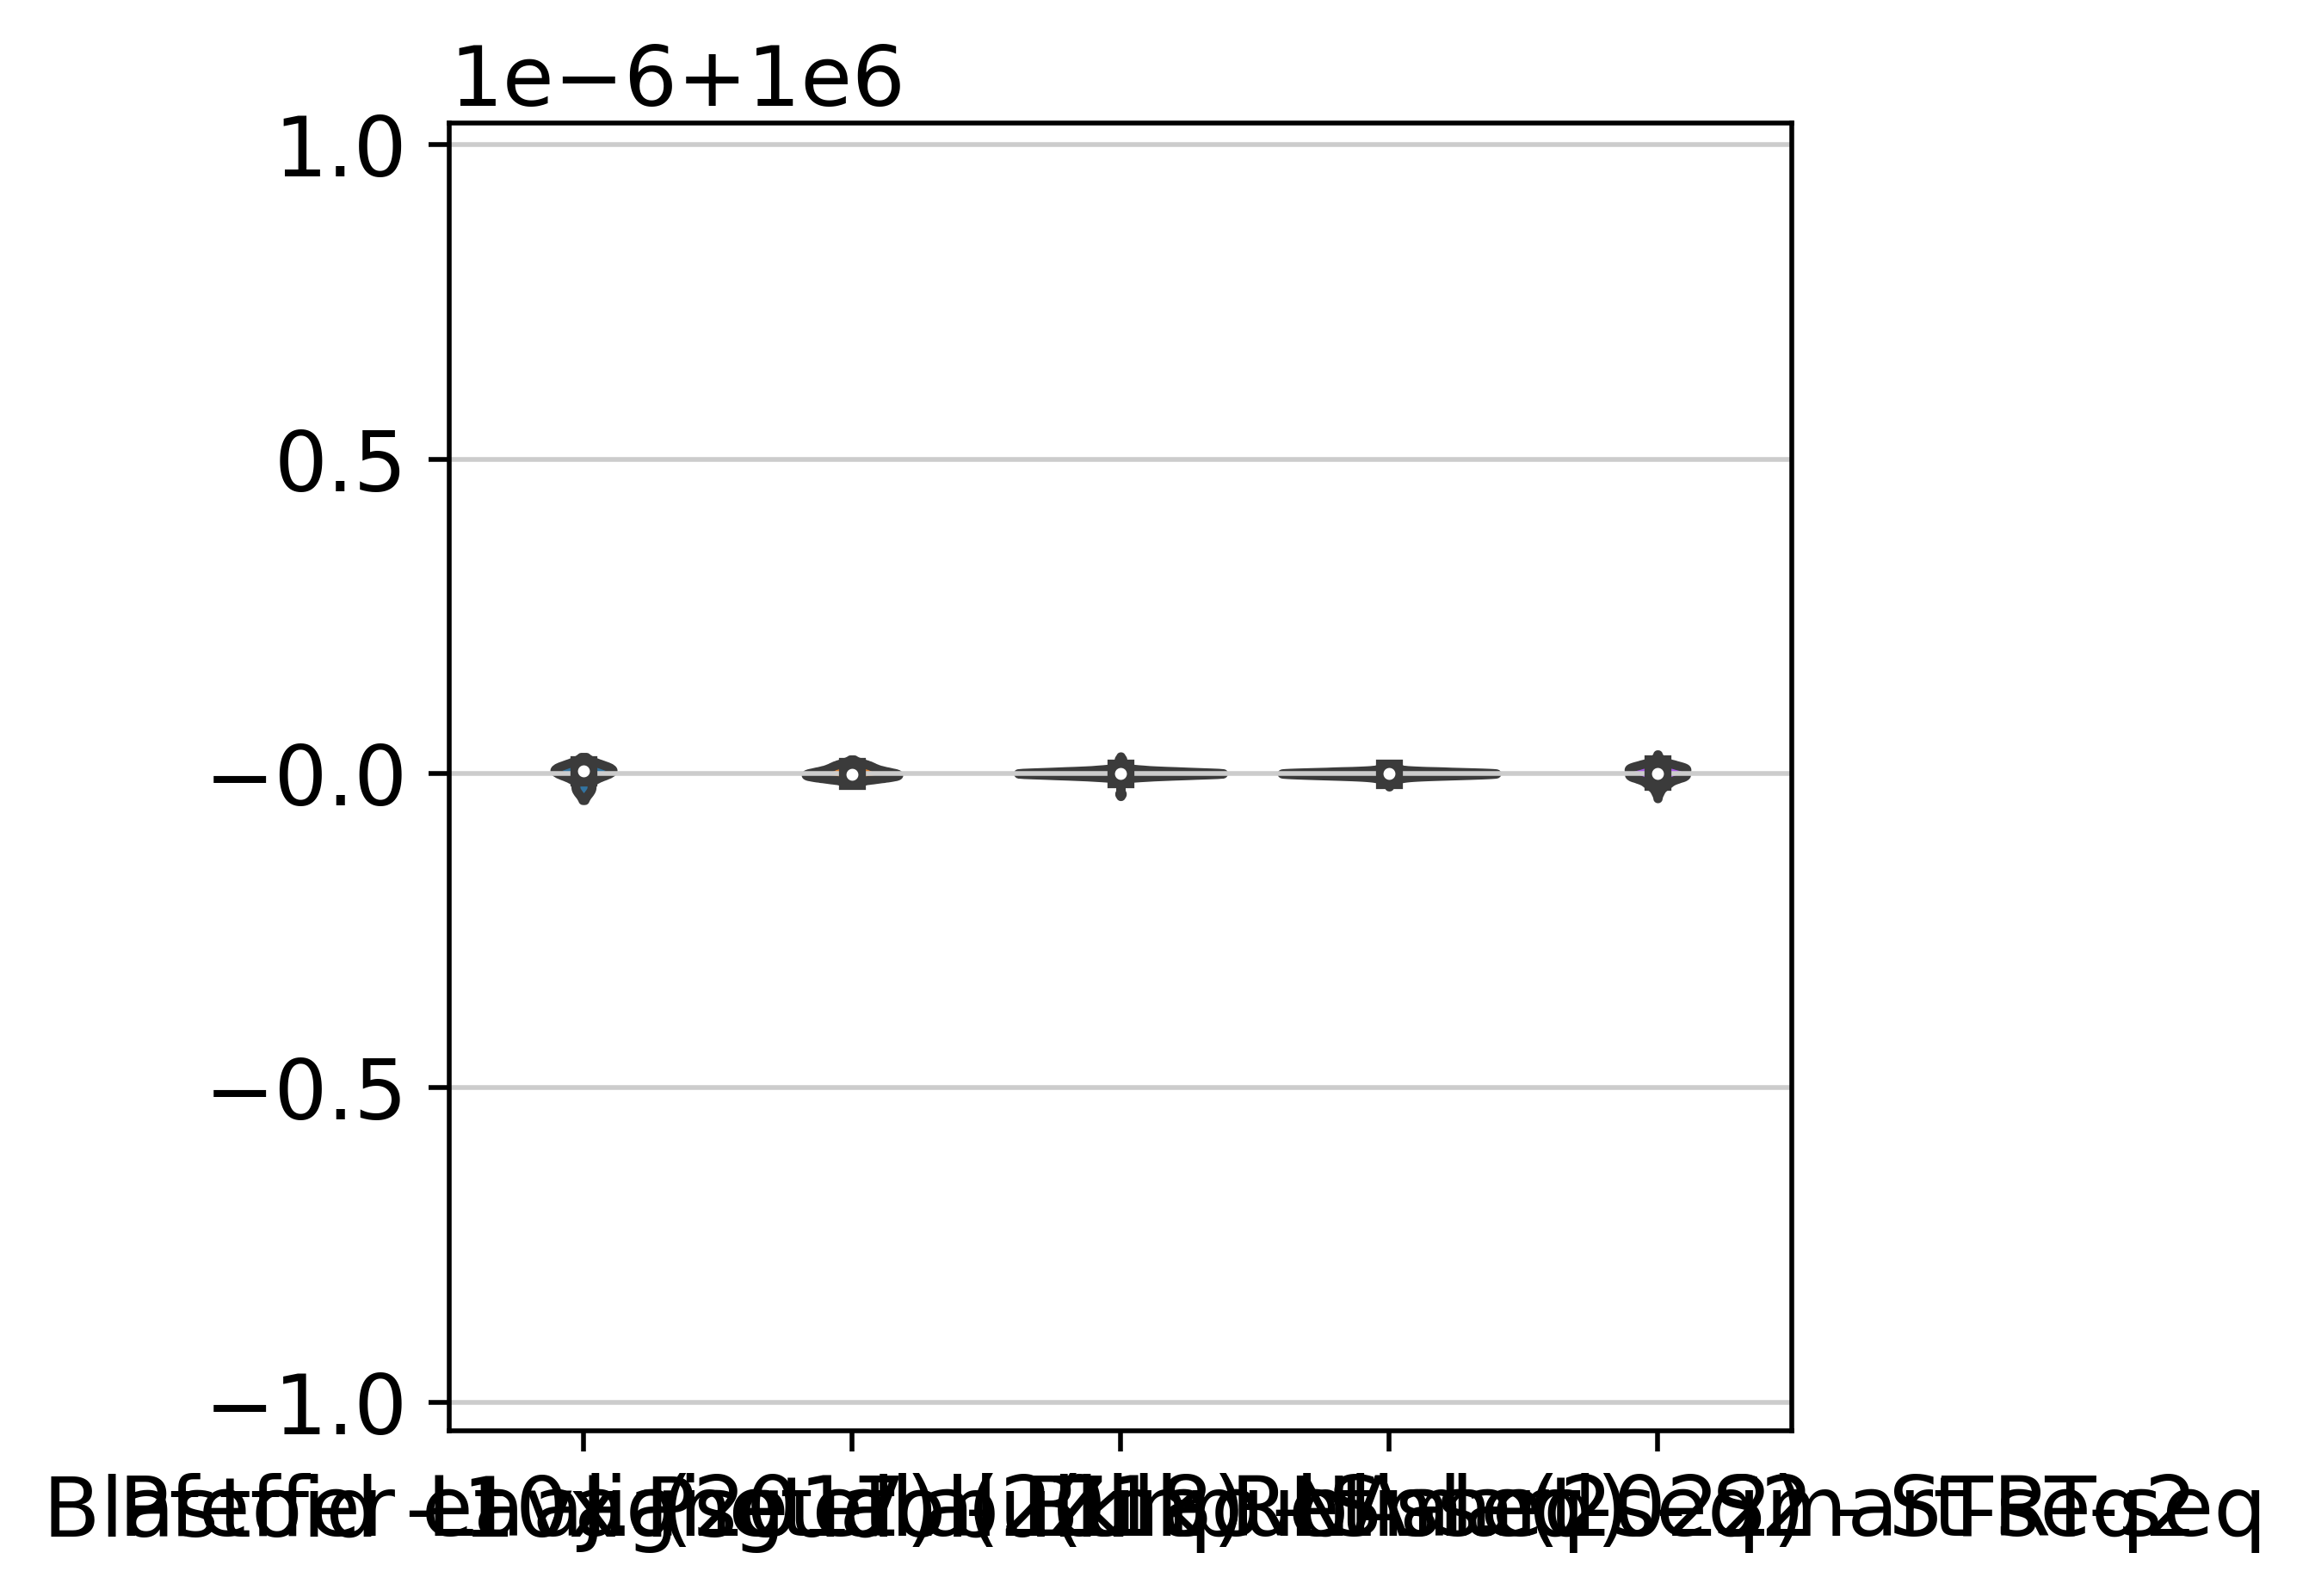

In [34]:
finalt = 1000000 * alltf.div(alltf.sum(axis=1), axis=0)
sns.violinplot(y = finalt.sum(axis=1), x=datas)

In [35]:
altlog = np.log1p(finalt)

# PCA

In [36]:
scale = StandardScaler()
pca = PCA(n_components=2)


all_scale = scale.fit_transform(altlog)
model = pca.fit(all_scale)
all_pca_tpm = model.transform(all_scale)

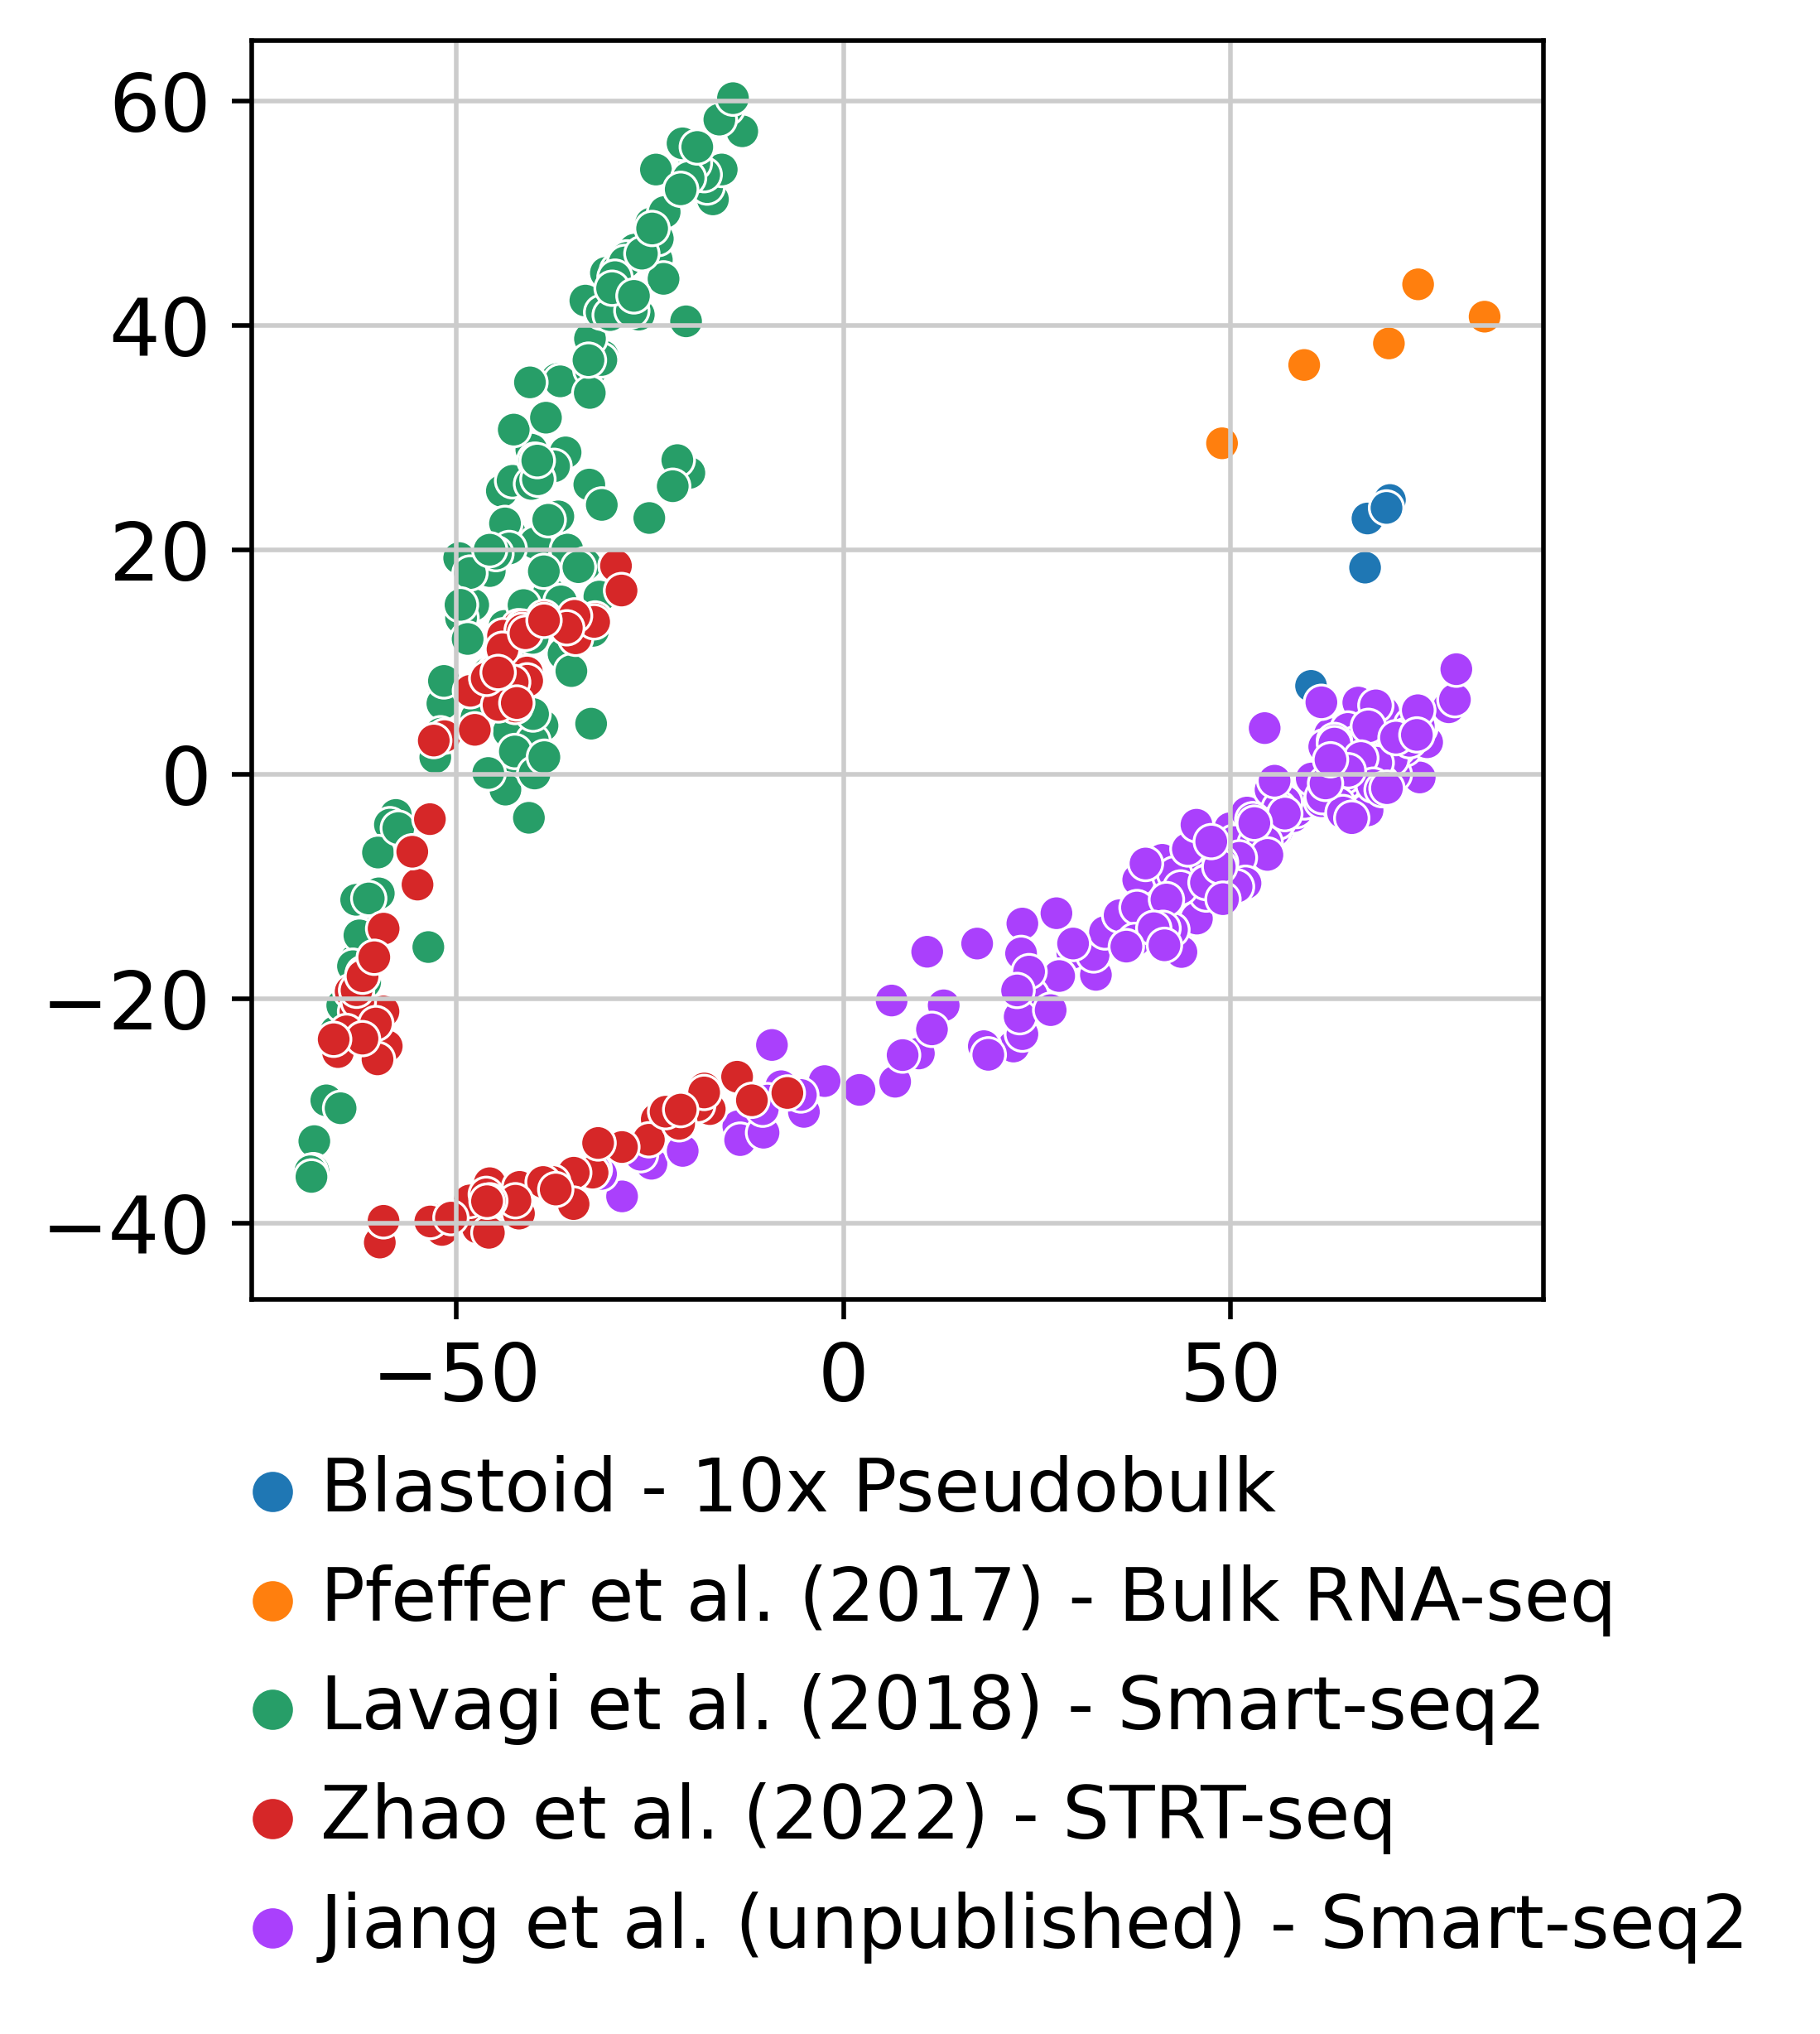

In [37]:
ax = sns.scatterplot(x=[i[0] for i in all_pca_tpm], y=[i[1] for i in all_pca_tpm], hue=datas,
                     hue_order = ["Blastoid - 10x Pseudobulk", "Pfeffer et al. (2017) - Bulk RNA-seq", "Lavagi et al. (2018) - Smart-seq2", "Zhao et al. (2022) - STRT-seq", "Jiang et al. (unpublished) - Smart-seq2"])
sns.move_legend(ax, "upper left",
    bbox_to_anchor=(-0.05, -0.07), ncol=1, title=None, frameon=False)
plt.savefig('Figures/S2A.pdf',  bbox_inches='tight') 

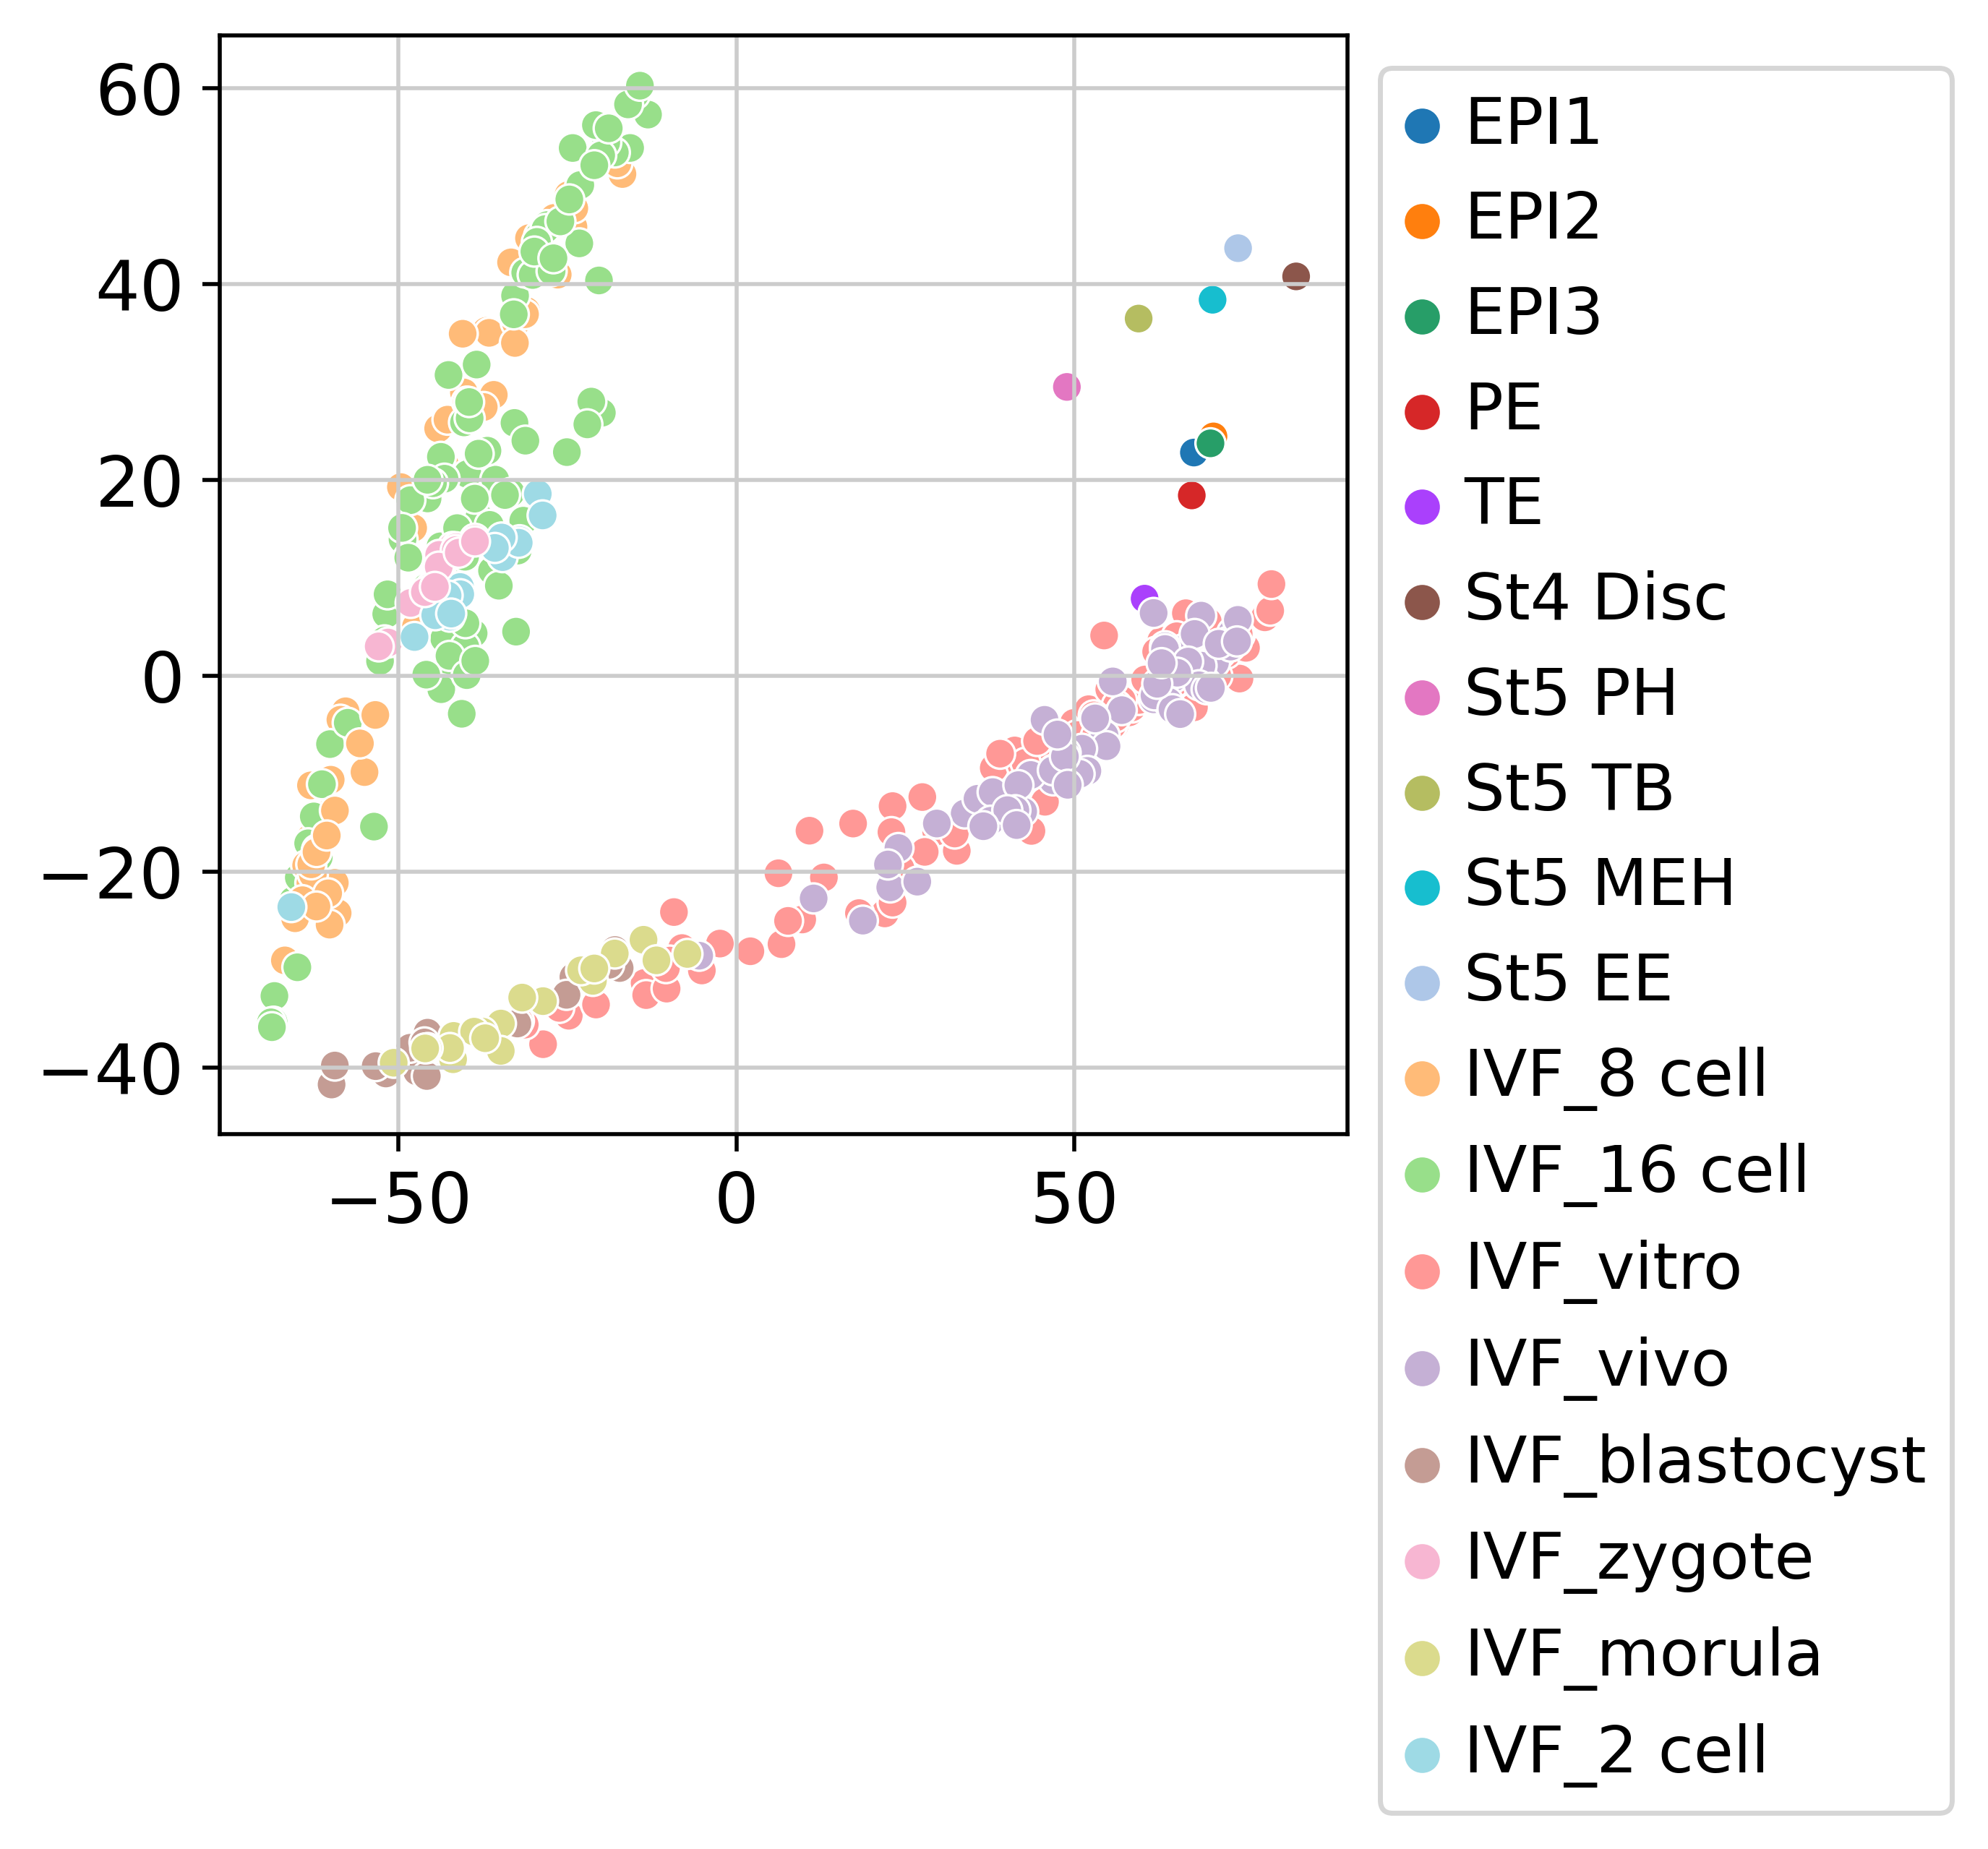

In [38]:
ax = sns.scatterplot(x=[i[0] for i in all_pca_tpm], y=[i[1] for i in all_pca_tpm], hue=lines)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('Figures/2C.pdf', bbox_inches='tight') 
#embryonic ectoderm (EmE)
#mesoderm, endoderm and visceral hypoblast (MEH)
#trophoblast (TB);
#parietal hypoblast. 

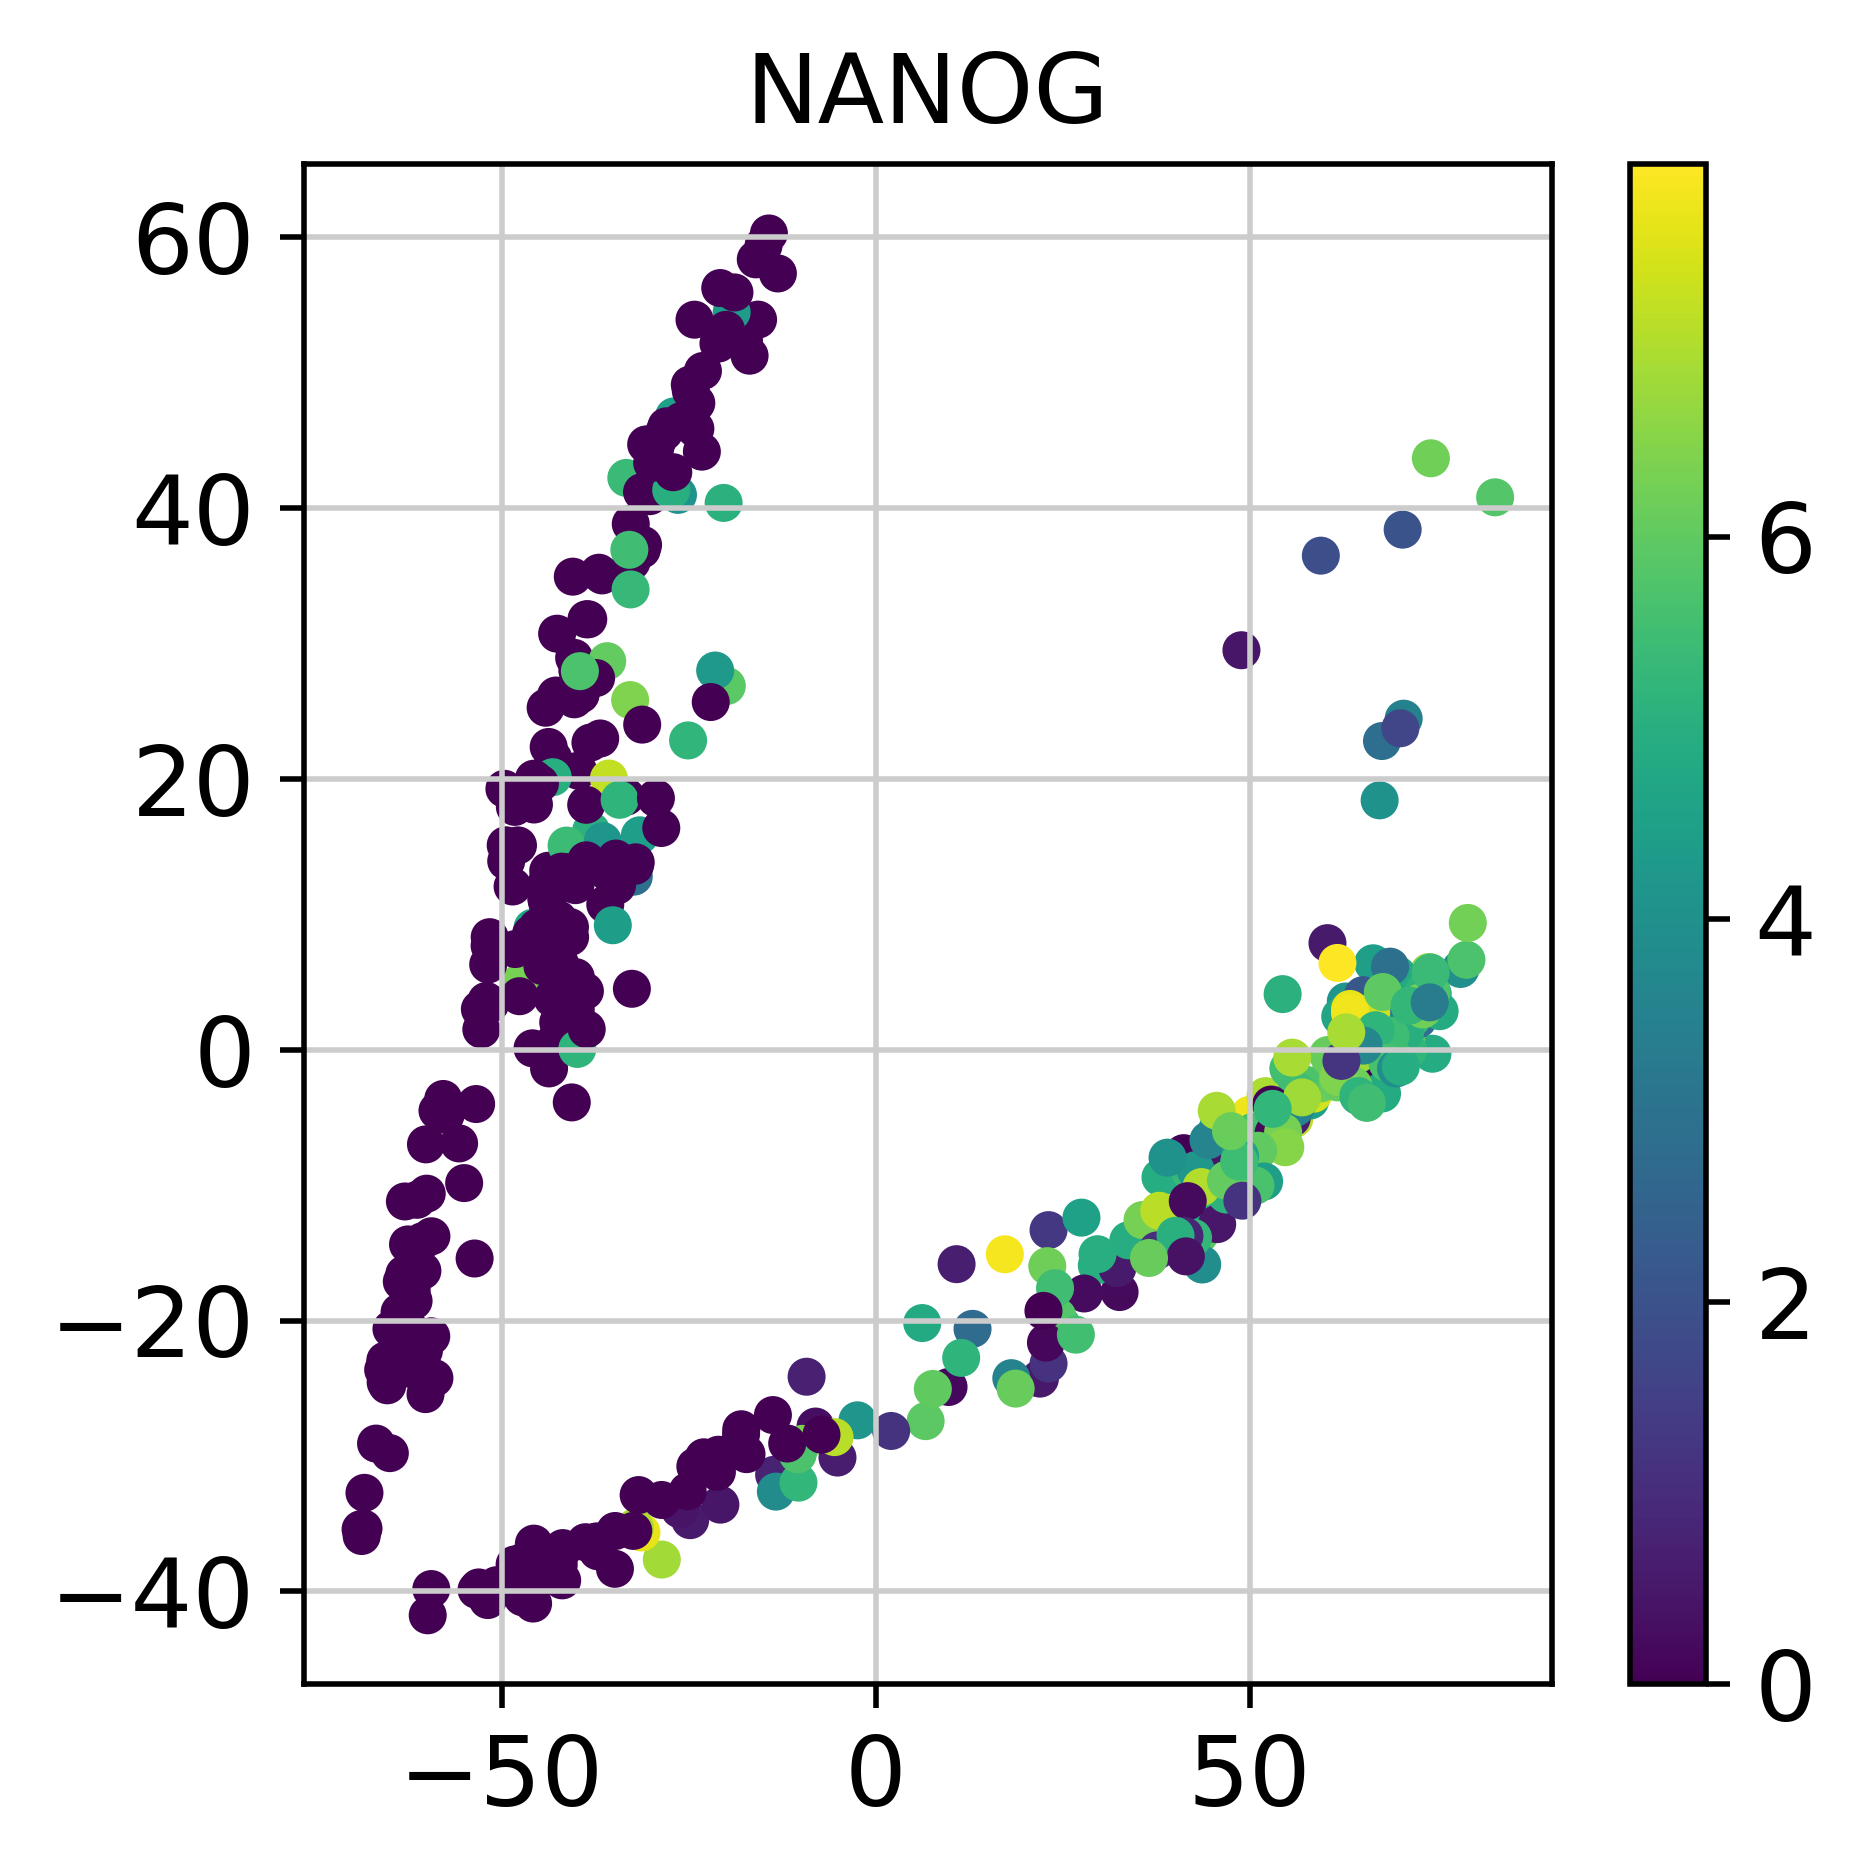

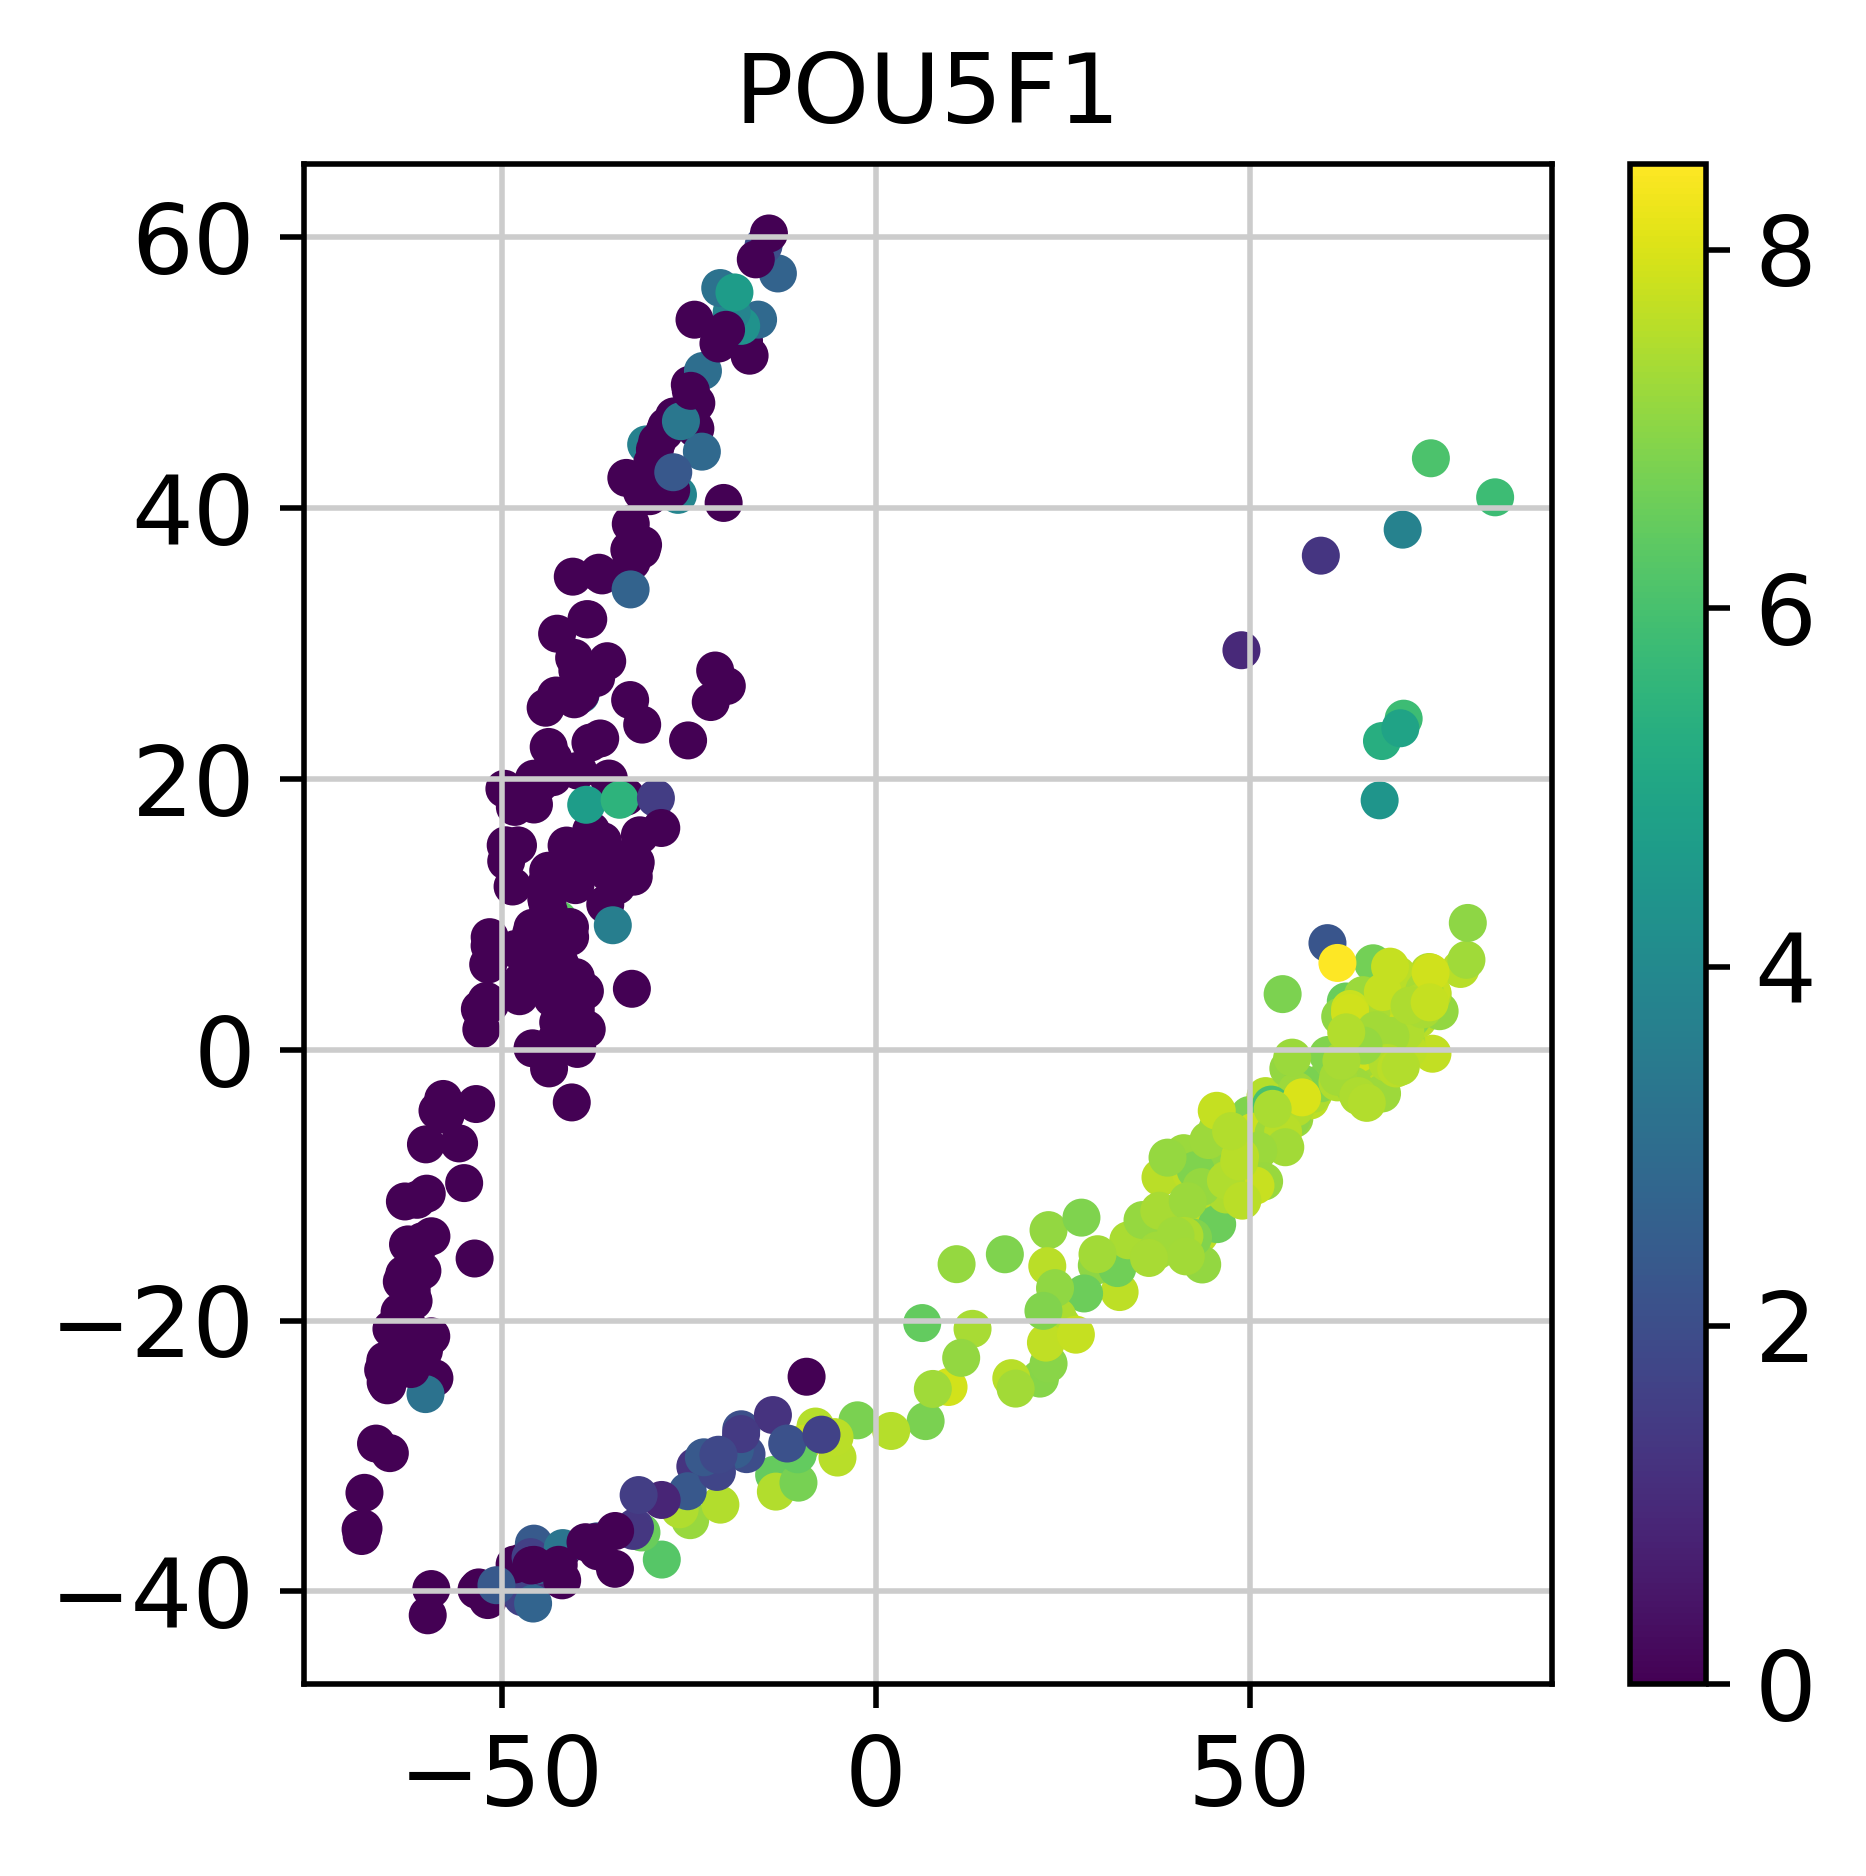

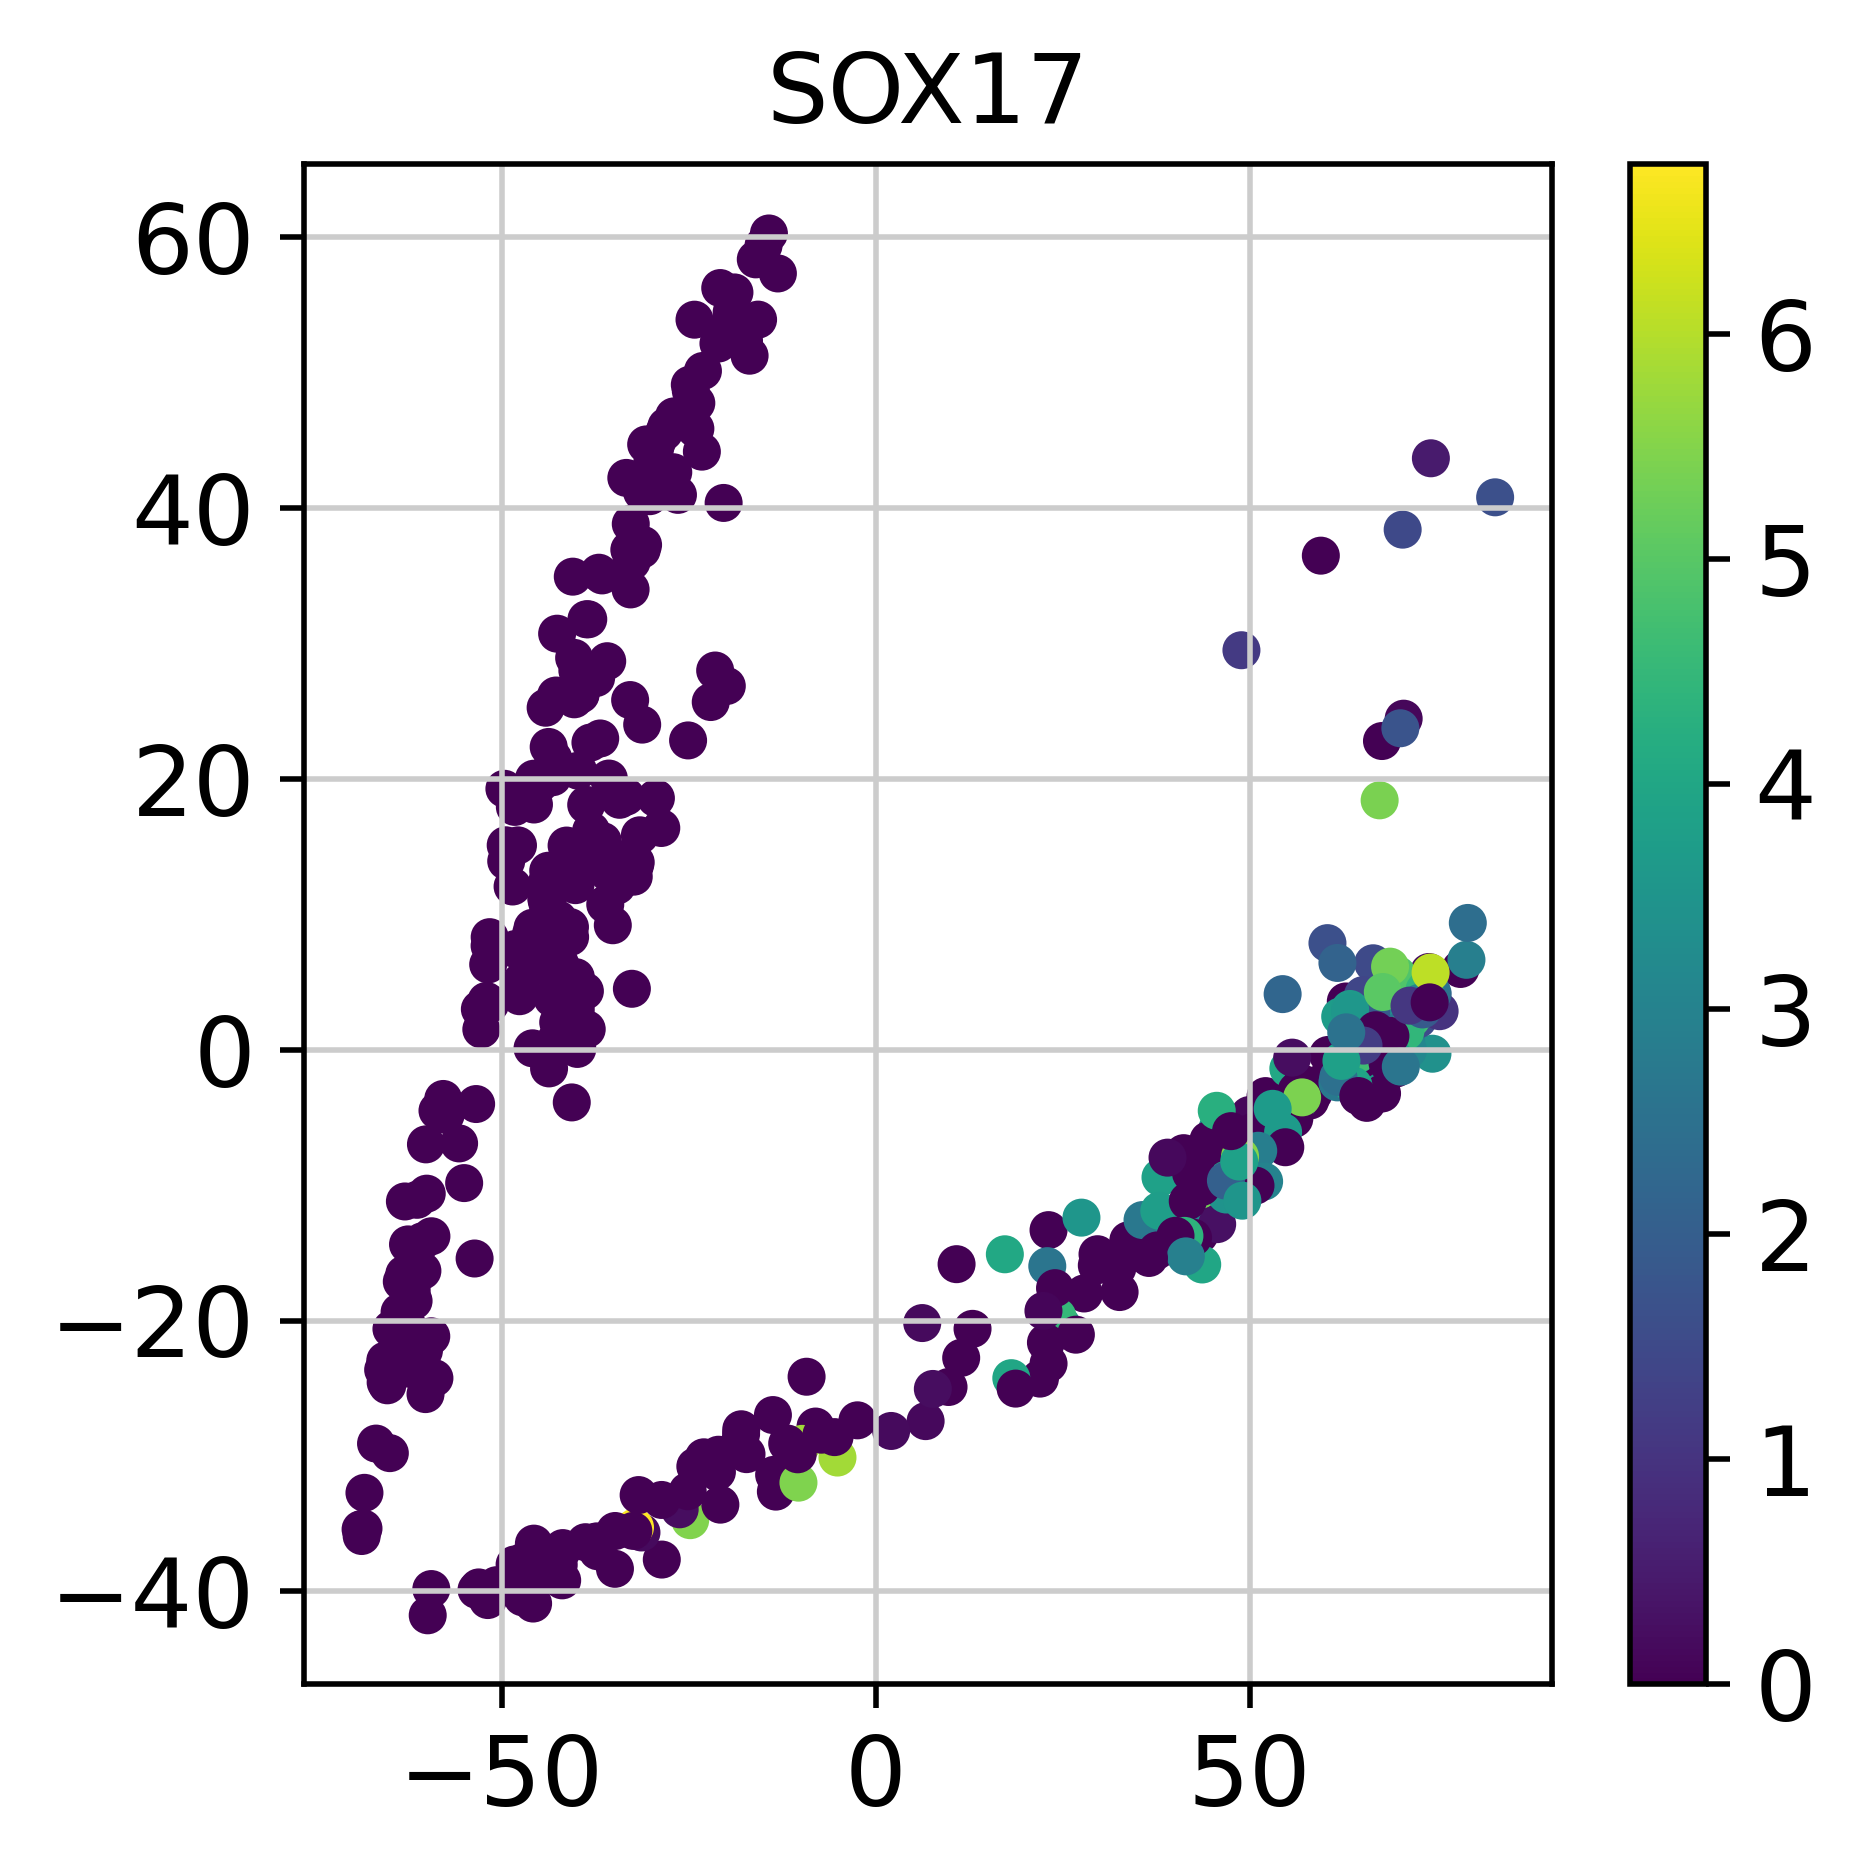

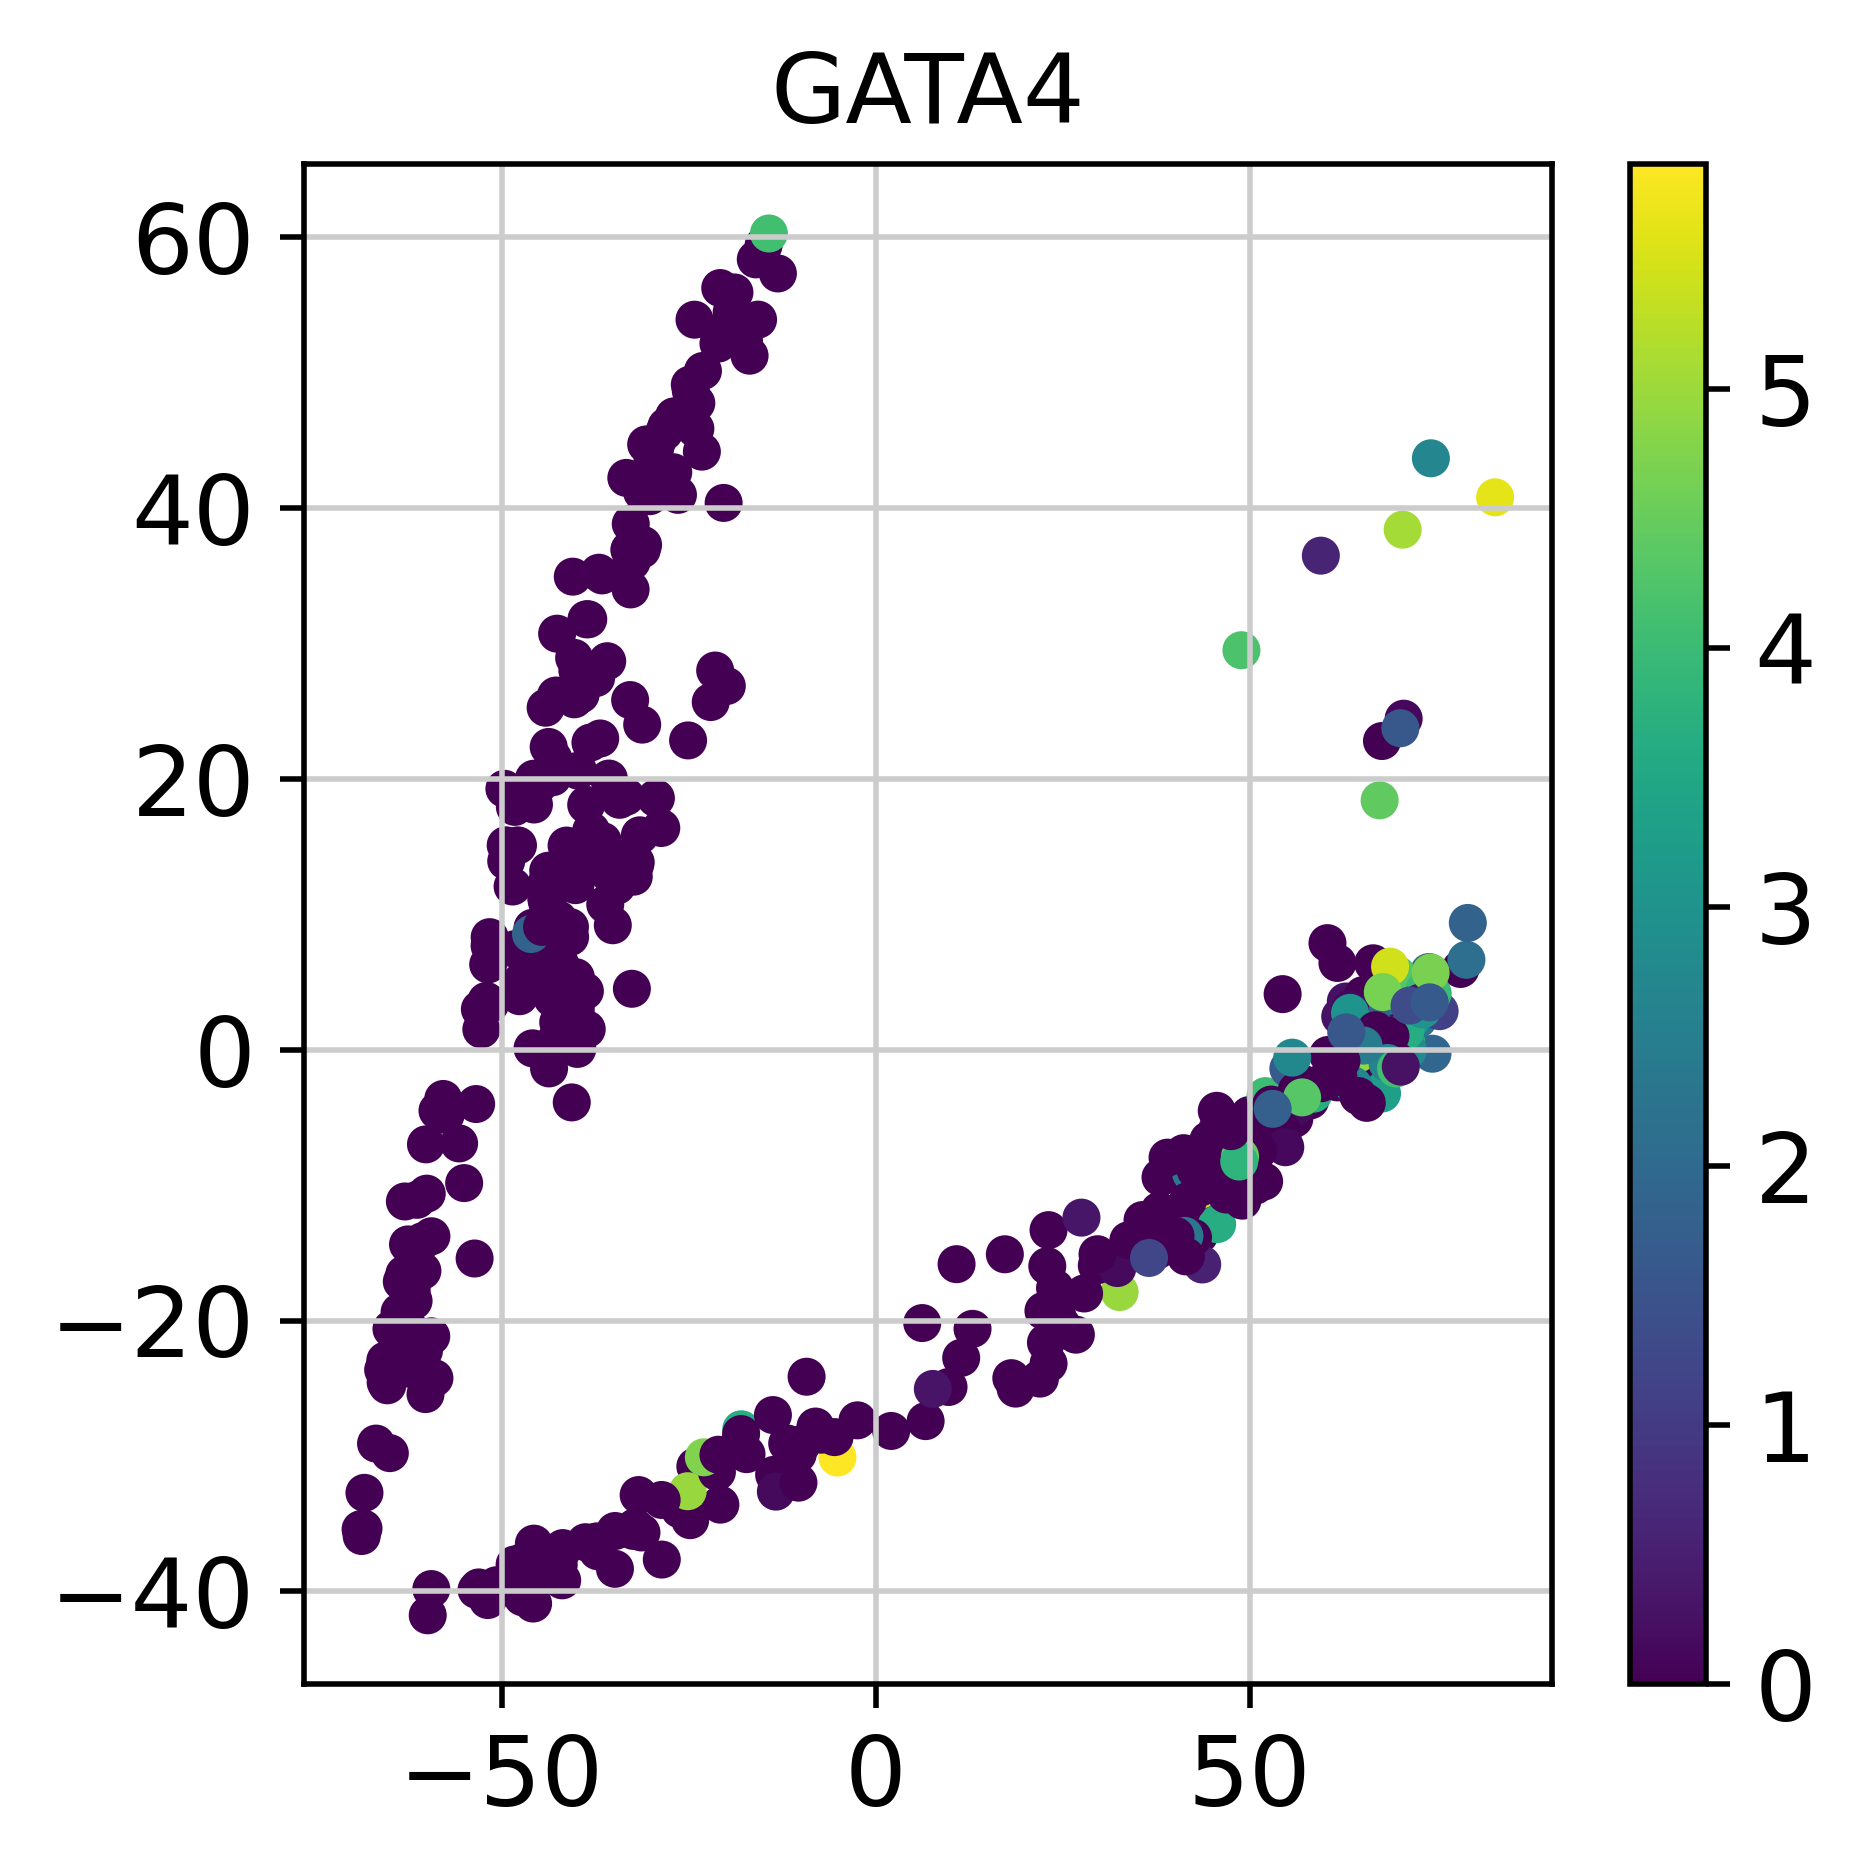

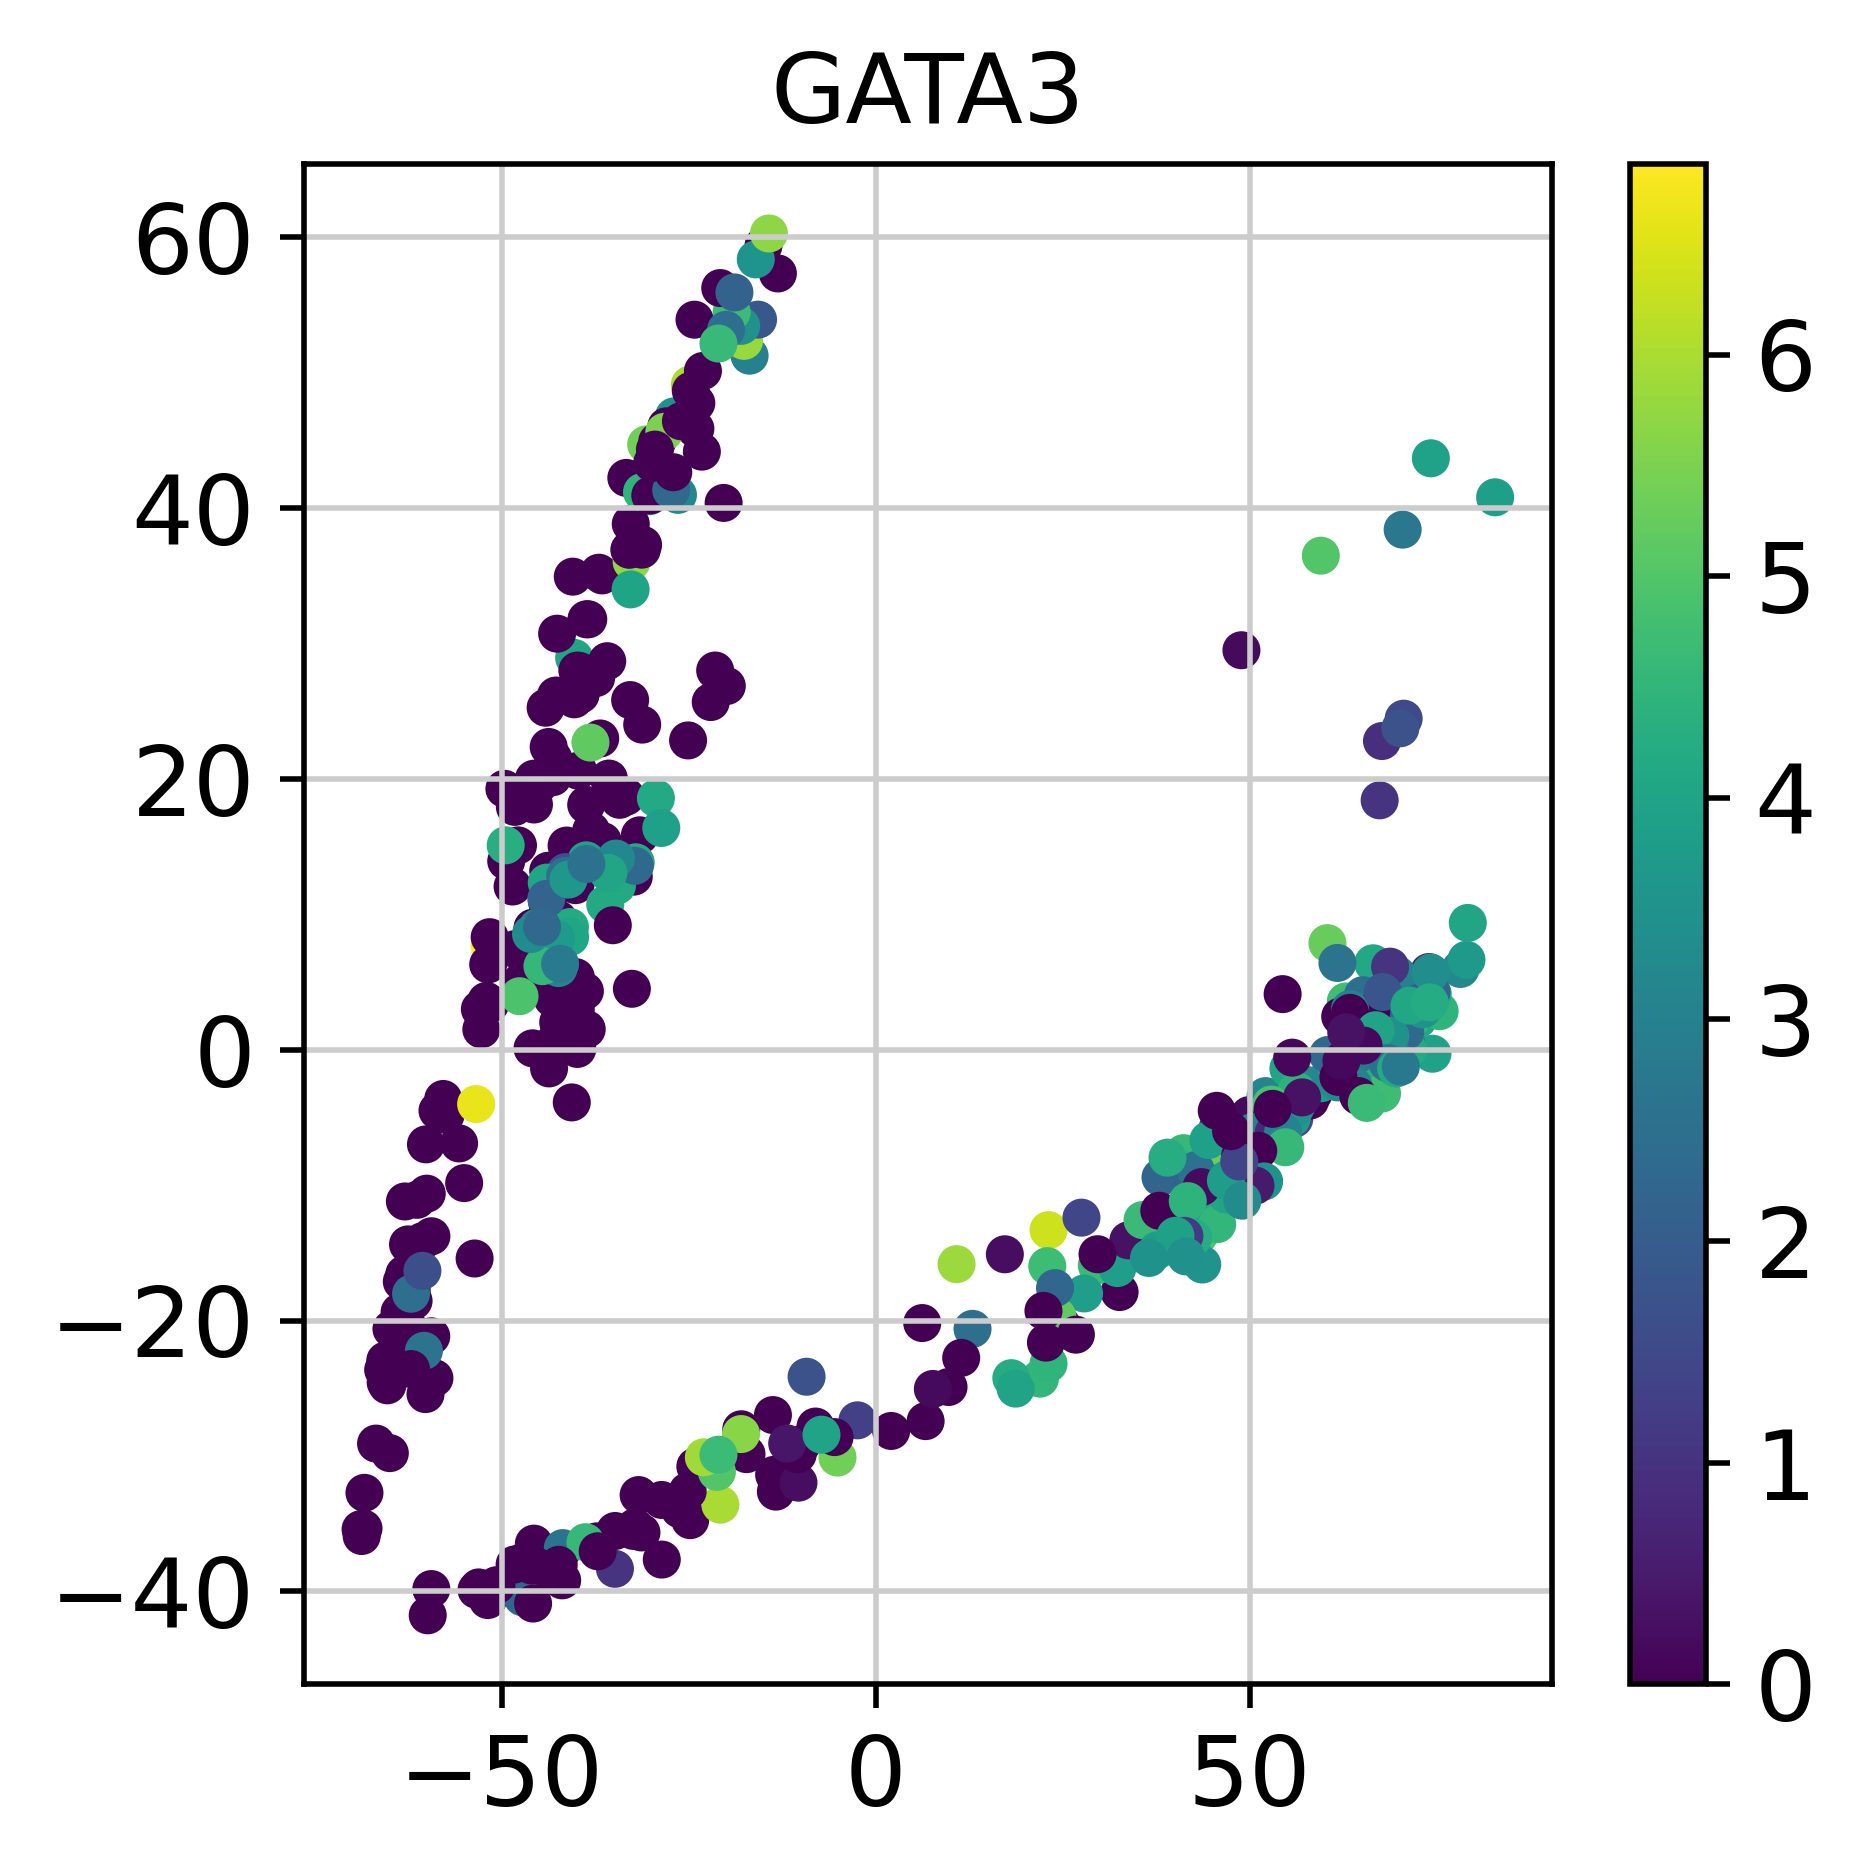

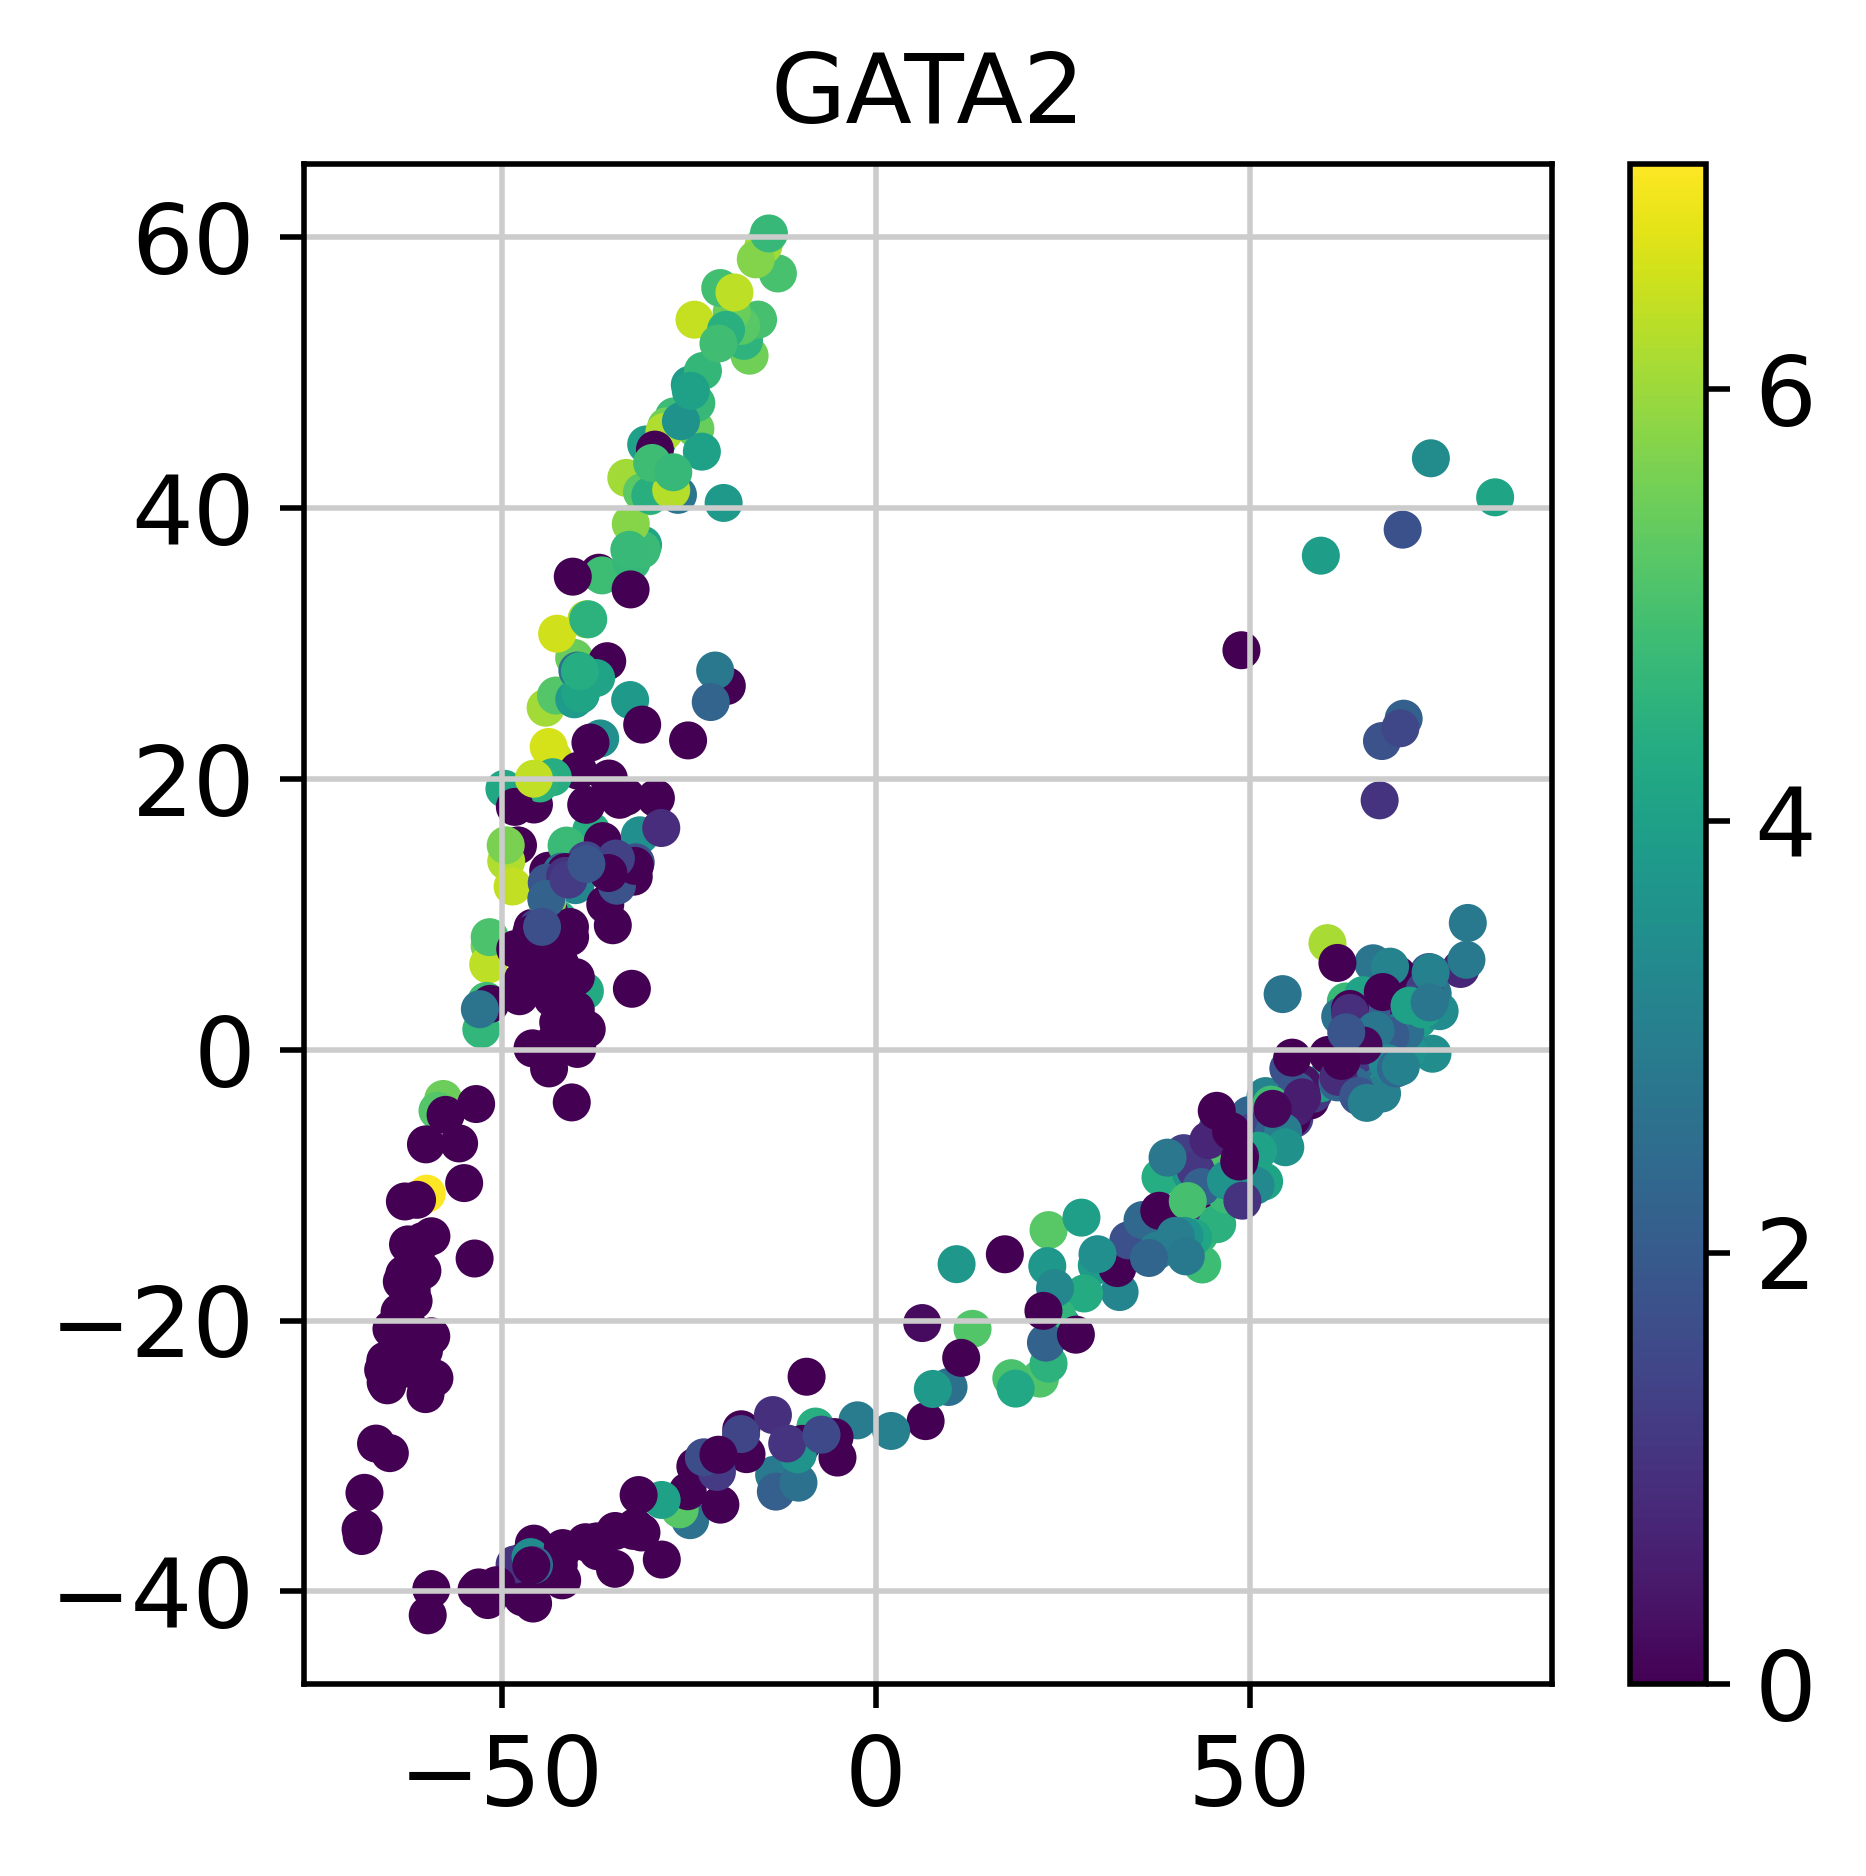

In [39]:
genes = ['NANOG', "POU5F1", 'SOX17', 'GATA4', 'GATA3', 'GATA2']
letters = {'NANOG':"B", "POU5F1":"B", 'SOX17':"C", 'GATA4':"C", 'GATA3':"D", 'GATA2':"D"}
for i in genes:
  gene = altlog[i].values.tolist()
  #cm = plt.cm.get_cmap('viridis')
  ax = plt.scatter([i[0] for i in all_pca_tpm], [i[1] for i in all_pca_tpm], s=20, c=gene, cmap='viridis')
  plt.colorbar(ax)
  plt.title(i)
  plt.savefig('Figures/S2' + letters[i] + '_' + i + '.pdf')
  if i in ["GATA3", "SOX17", "POU5F1"]:
    plt.savefig('Figures/2D_' + i + '.pdf')
  plt.show()